In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from glob import glob
import os
import random
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

2025-07-01 15:59:44.444051: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751385584.661377      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751385584.725592      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
def L1DistLayer():
    class L1Dist(tf.keras.layers.Layer):
        def __init__(self, **kwargs):
            super().__init__()
        def call(self, input_embedding, validation_embedding):
            return tf.math.abs(input_embedding - validation_embedding)
    return L1Dist

In [4]:
model = load_model("/kaggle/input/multiclass_face_verification/keras/default/1/face_verifier.h5", custom_objects={'L1Dist': L1DistLayer()})

I0000 00:00:1751385614.921100      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1751385614.921743      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [5]:
def get_all_images(root_dir):
    person_images = {}
    for person in os.listdir(root_dir):
        person_path = os.path.join(root_dir, person)
        if os.path.isdir(person_path):
            distorted_folder = os.path.join(person_path, 'distortion')
            distorted_images = glob(os.path.join(distorted_folder, '*.jpg'))
            clean_images = [f for f in glob(os.path.join(person_path, '*.jpg')) if 'distortion' not in f]
            if len(clean_images) >= 1 and len(distorted_images) >= 1:
                person_images[person_path] = {
                    'clean': clean_images,
                    'distorted': distorted_images
                }
    return person_images


In [6]:
def create_pairs(person_images, num_neg_pairs=500):
    pairs = []
    persons = list(person_images.keys())
    for person in persons:
        clean_img = person_images[person]['clean'][0]
        distorted_imgs = person_images[person]['distorted']
        for d in distorted_imgs:
            pairs.append((clean_img, d, 1))
    while len([p for p in pairs if p[2] == 0]) < num_neg_pairs:
        p1, p2 = random.sample(persons, 2)
        img1 = random.choice(person_images[p1]['clean'] + person_images[p1]['distorted'])
        img2 = random.choice(person_images[p2]['clean'] + person_images[p2]['distorted'])
        pairs.append((img1, img2, 0))
    return pairs


In [7]:
def preprocess(path):
    byte_img = tf.io.read_file(path)
    img = tf.io.decode_jpeg(byte_img, channels=3)
    img = tf.image.resize(img, (160, 160))
    img = preprocess_input(img)
    return img

In [8]:
def get_dataset(pairs):
    images1 = [preprocess(p[0]).numpy() for p in pairs]
    images2 = [preprocess(p[1]).numpy() for p in pairs]
    labels = [p[2] for p in pairs]
    return np.array(images1), np.array(images2), np.array(labels)

In [9]:
VAL_ROOT = "/kaggle/input/task-b-test-dataset/Comys_Hackathon5/Task_B/val"
val_images = get_all_images(VAL_ROOT)
val_pairs = create_pairs(val_images, num_neg_pairs=500)
x1, x2, y_true = get_dataset(val_pairs)

preds = model.predict([x1, x2])
y_pred = (preds > 0.5).astype(int).flatten()

print("Accuracy:", accuracy_score(y_true, y_pred))
print("Precision:", precision_score(y_true, y_pred))
print("Recall:", recall_score(y_true, y_pred))
print("F1 Score:", f1_score(y_true, y_pred))

I0000 00:00:1751385720.709847      95 service.cc:148] XLA service 0x7f174403d960 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751385720.710825      95 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1751385720.710848      95 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1751385721.637820      95 cuda_dnn.cc:529] Loaded cuDNN version 90300


  5/108 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step

I0000 00:00:1751385725.330258      95 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


108/108 ━━━━━━━━━━━━━━━━━━━━ 16s 84ms/step
Accuracy: 0.8630573248407644
Precision: 0.8626132709733996
Recall: 0.9989844278943805
F1 Score: 0.9258039215686275


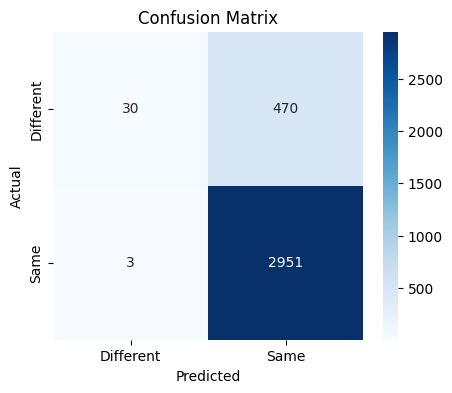

In [10]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Different', 'Same'], yticklabels=['Different', 'Same'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


Correct Matches:


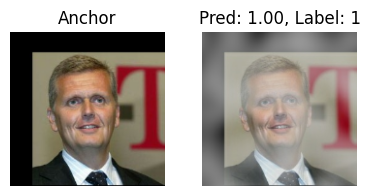

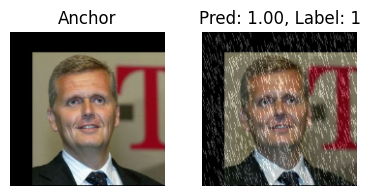

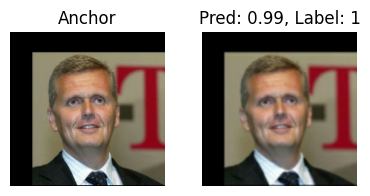

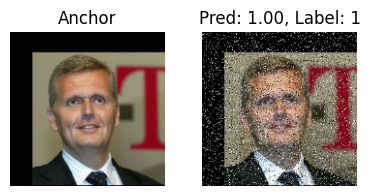

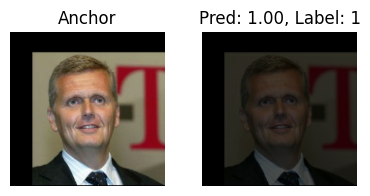

In [11]:
correct_match_idx = [i for i in range(len(y_true)) if y_true[i] == 1 and y_pred[i] == 1]
print("\nCorrect Matches:")
for i in correct_match_idx[:5]:
    plt.figure(figsize=(4,2))
    plt.subplot(1,2,1)
    plt.imshow((x1[i] + 1) / 2)  # Convert from [-1,1] to [0,1]
    plt.title("Anchor")
    plt.axis('off')

    plt.subplot(1,2,2)
    plt.imshow((x2[i] + 1) / 2)
    plt.title(f"Pred: {preds[i][0]:.2f}, Label: 1")
    plt.axis('off')
    plt.tight_layout()
    plt.show()


Correct Mismatches:


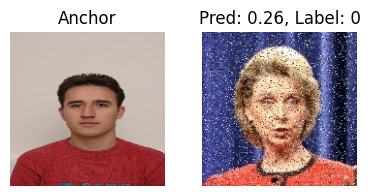

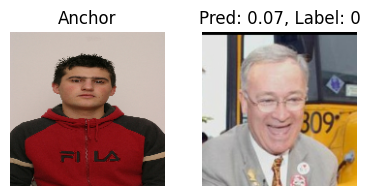

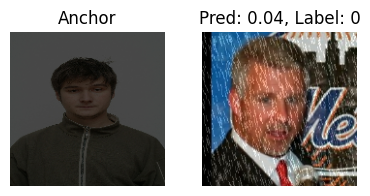

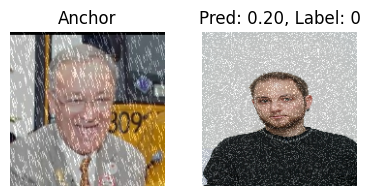

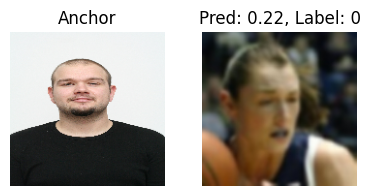

In [12]:
correct_mismatch_idx = [i for i in range(len(y_true)) if y_true[i] == 0 and y_pred[i] == 0]
print("\nCorrect Mismatches:")
for i in correct_mismatch_idx[:5]:
    plt.figure(figsize=(4,2))
    plt.subplot(1,2,1)
    plt.imshow((x1[i] + 1) / 2)
    plt.title("Anchor")
    plt.axis('off')

    plt.subplot(1,2,2)
    plt.imshow((x2[i] + 1) / 2)
    plt.title(f"Pred: {preds[i][0]:.2f}, Label: 0")
    plt.axis('off')
    plt.tight_layout()
    plt.show()
